###  Eigenvalues vs Singular values

This notebook empirically examines dynamical similarity metrics and investigates how comparing the eigenvalues and singular values of the Koopman matrix affects these metrics, as a response to pull request 1.

In [3]:
from koopstd.dynametric import KoopOpMetric
from koopstd.eval import MetricEvaluator
from koopstd.datasets import Lorenz63
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
import pandas as pd

def plot_comparison(dist_matrices, method_name, info):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    attractor_names = info['types']
    tick_positions = info['tick_positions']

    for i, (dist_matrix, feature_type) in enumerate(zip(dist_matrices, ['eig', 'sv'])):
        row = i  # 0 for eig, 1 for sv

        # Plot heatmap
        sns.heatmap(dist_matrix, cmap='viridis', ax=axes[row, 0])
        axes[row, 0].set_title(f'{method_name} Distance Matrix ({feature_type})')
        axes[row, 0].set_xticks(tick_positions)
        axes[row, 0].set_yticks(tick_positions)
        axes[row, 0].set_xticklabels(attractor_names, rotation=45, ha='right')
        axes[row, 0].set_yticklabels(attractor_names, rotation=0)

        # Perform MDS for visualization
        vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        embedding = vis.fit_transform(dist_matrix)

        # Create DataFrame for scatter plot
        df = pd.DataFrame()
        df["x"] = embedding[:, 0]
        df["y"] = embedding[:, 1]
        system_labels = []
        # Adjust the number of points per attractor type based on your data
        n_per_type = dist_matrix.shape[0] // len(attractor_names)
        for attractor_type in attractor_names:
            system_labels.extend([attractor_type] * n_per_type)
        df["System"] = system_labels

        # Plot scatter with improved styling
        sns.scatterplot(data=df, x="x", y="y", hue="System", ax=axes[row, 1], s=80, alpha=0.8)
        axes[row, 1].set_title(f'MDS Projection of {method_name} Distances ({feature_type})')
        axes[row, 1].set_xlabel('MDS Component 1')
        axes[row, 1].set_ylabel('MDS Component 2')
        axes[row, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return plt
    

### KoopSTD

Although our paper focuses on eigenvalues, we found that the results (by silhoutte coefficient) are relatively consistent when using singular values instead. This can be seen, for example, in the Lorenz63 dataset:

The silhouette scores of KoopSTD: eigenvalues 0.9238745348668709, singular values 0.9029201719752965


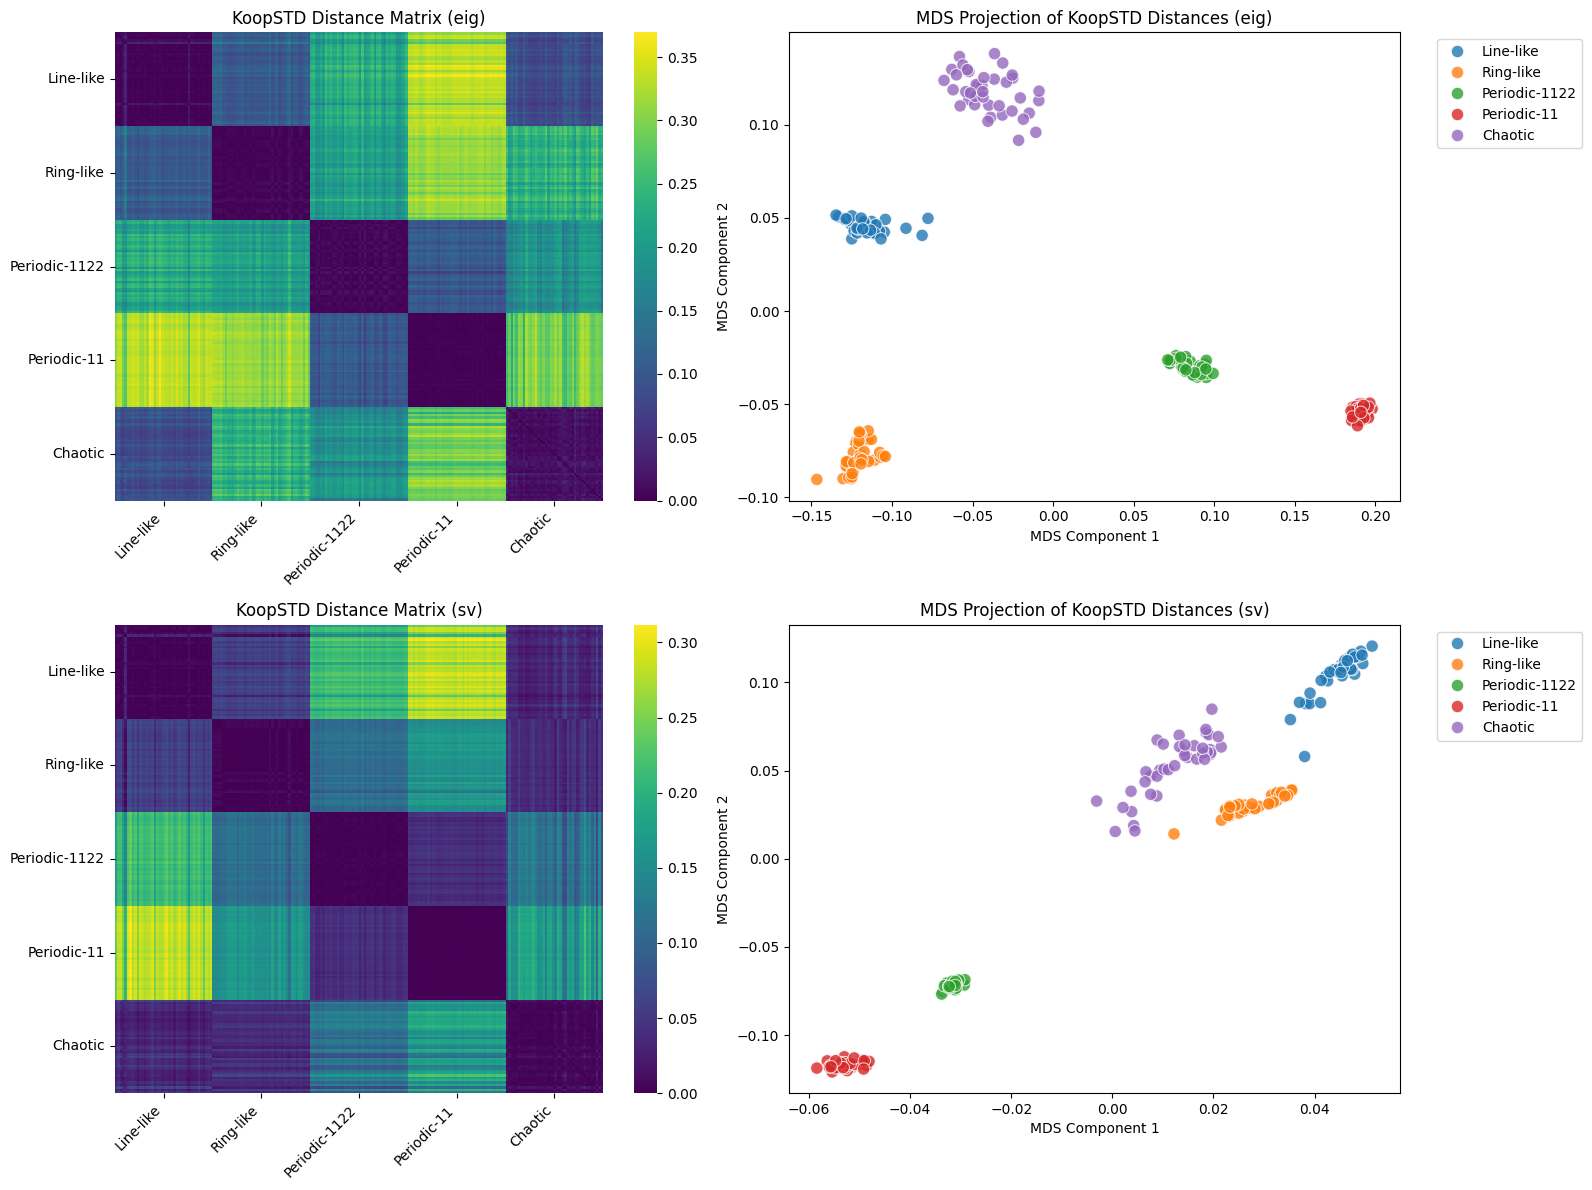

In [11]:
lorenz = Lorenz63(rho_values=[10, 20, 152, 220, 75], num_clips=40)
data = lorenz.data

info = {
    'types': ['Line-like', 'Ring-like', 'Periodic-1122', 'Periodic-11', 'Chaotic'],
    'tick_positions': [20, 60, 100, 140, 180]
}

wasserstein_compares = ["eig", "sv"]
silhouette_scores = []
koopstd_dist_matrices = []
for feature_type in wasserstein_compares:
    koopstd = KoopOpMetric(X=data, 
                           kmd_method='koopstd', kmd_params={'hop_size': 1, 'win_len': 500, 'rank': 10, 'lamb': 0.01}, 
                           dist='wasserstein', dist_params={'p': 1, 'method': 'emd', 'feature_type': feature_type}, device='cuda')
    koopstd_dist_matrix = koopstd.fit_score()
    koopstd_dist_matrices.append(koopstd_dist_matrix)

    me = MetricEvaluator(distance_matrix=koopstd_dist_matrix, cluster_sizes=[40, 40, 40, 40, 40])
    silhouette = me.evaluate()
    silhouette_scores.append(silhouette)

print(f"The silhouette scores of KoopSTD: eigenvalues {silhouette_scores[0]}, singular values {silhouette_scores[1]}")
plt = plot_comparison(koopstd_dist_matrices, "KoopSTD", info)
plt.show()

### HAVOK-based DSA (Ostrow et al., 2024)

To use the official implementation of DSA, install the package via:

```
pip install dsa-metric
```

The silhouette scores of DSA: eigenvalues 0.9815647174821759, singular values 0.4523271517420136


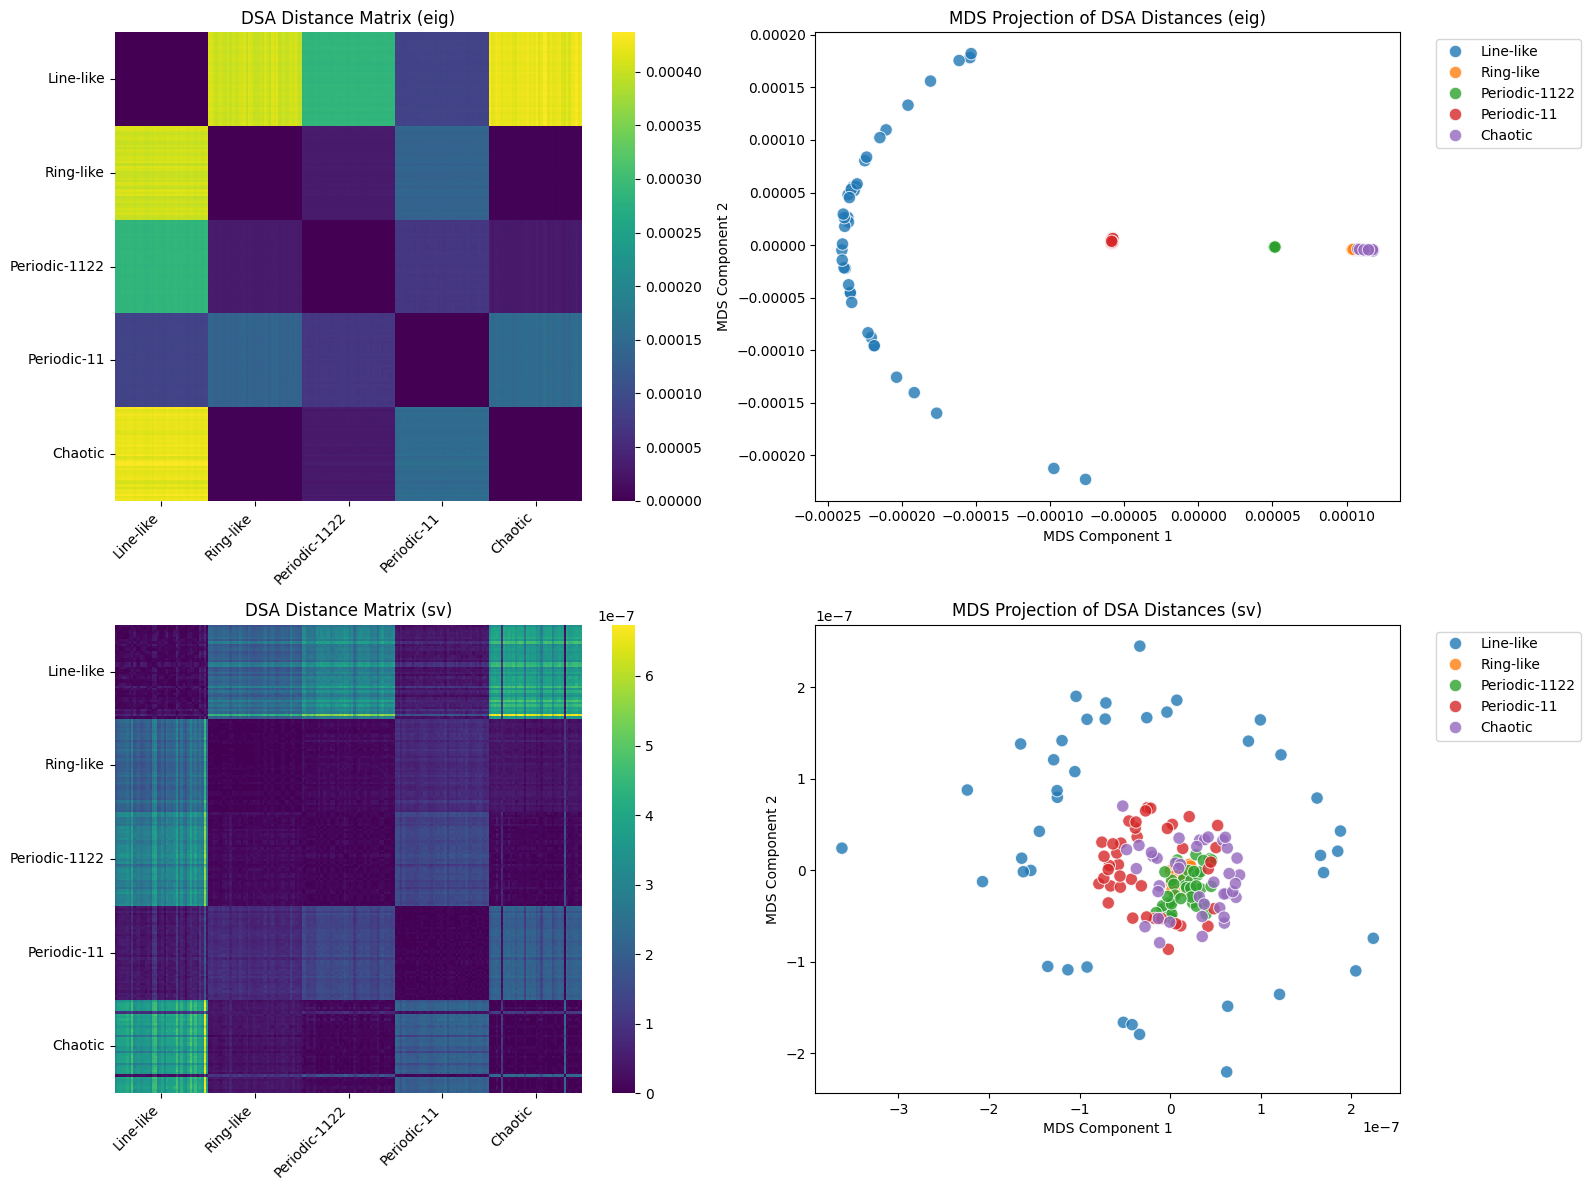

In [ ]:
from DSA import DSA

wasserstein_compares = ["eig", "sv"]
dsa_dist_matrices = []
silhouette_scores = []
for wasserstein_compare in wasserstein_compares:
    dsa = DSA(data, n_delays=40, rank=10, delay_interval=5, verbose=False, score_method="wasserstein", wasserstein_compare=wasserstein_compare, device="cuda")
    dsa_sim = dsa.fit_score()
    dsa_dist_matrices.append(dsa_sim)

    me = MetricEvaluator(distance_matrix=dsa_sim, cluster_sizes=[40, 40, 40, 40, 40])
    silhouette = me.evaluate()
    silhouette_scores.append(silhouette)

print(f"The silhouette scores of DSA: eigenvalues {silhouette_scores[0]}, singular values {silhouette_scores[1]}")

plt = plot_comparison(dsa_dist_matrices, "DSA", info)
plt.show()

Here, we observe a substantial gap between the results obtained using eigenvalues and those using singular values. In contrast, when applying the same analysis to 2D attractors for perceptual decision making (PDM attractors), the performance difference is minimal, with singular values even yielding a slightly higher silhouette coefficient.

The silhouette scores of DSA: eigenvalues 0.9001320335212976, singular values 0.9218882455703927


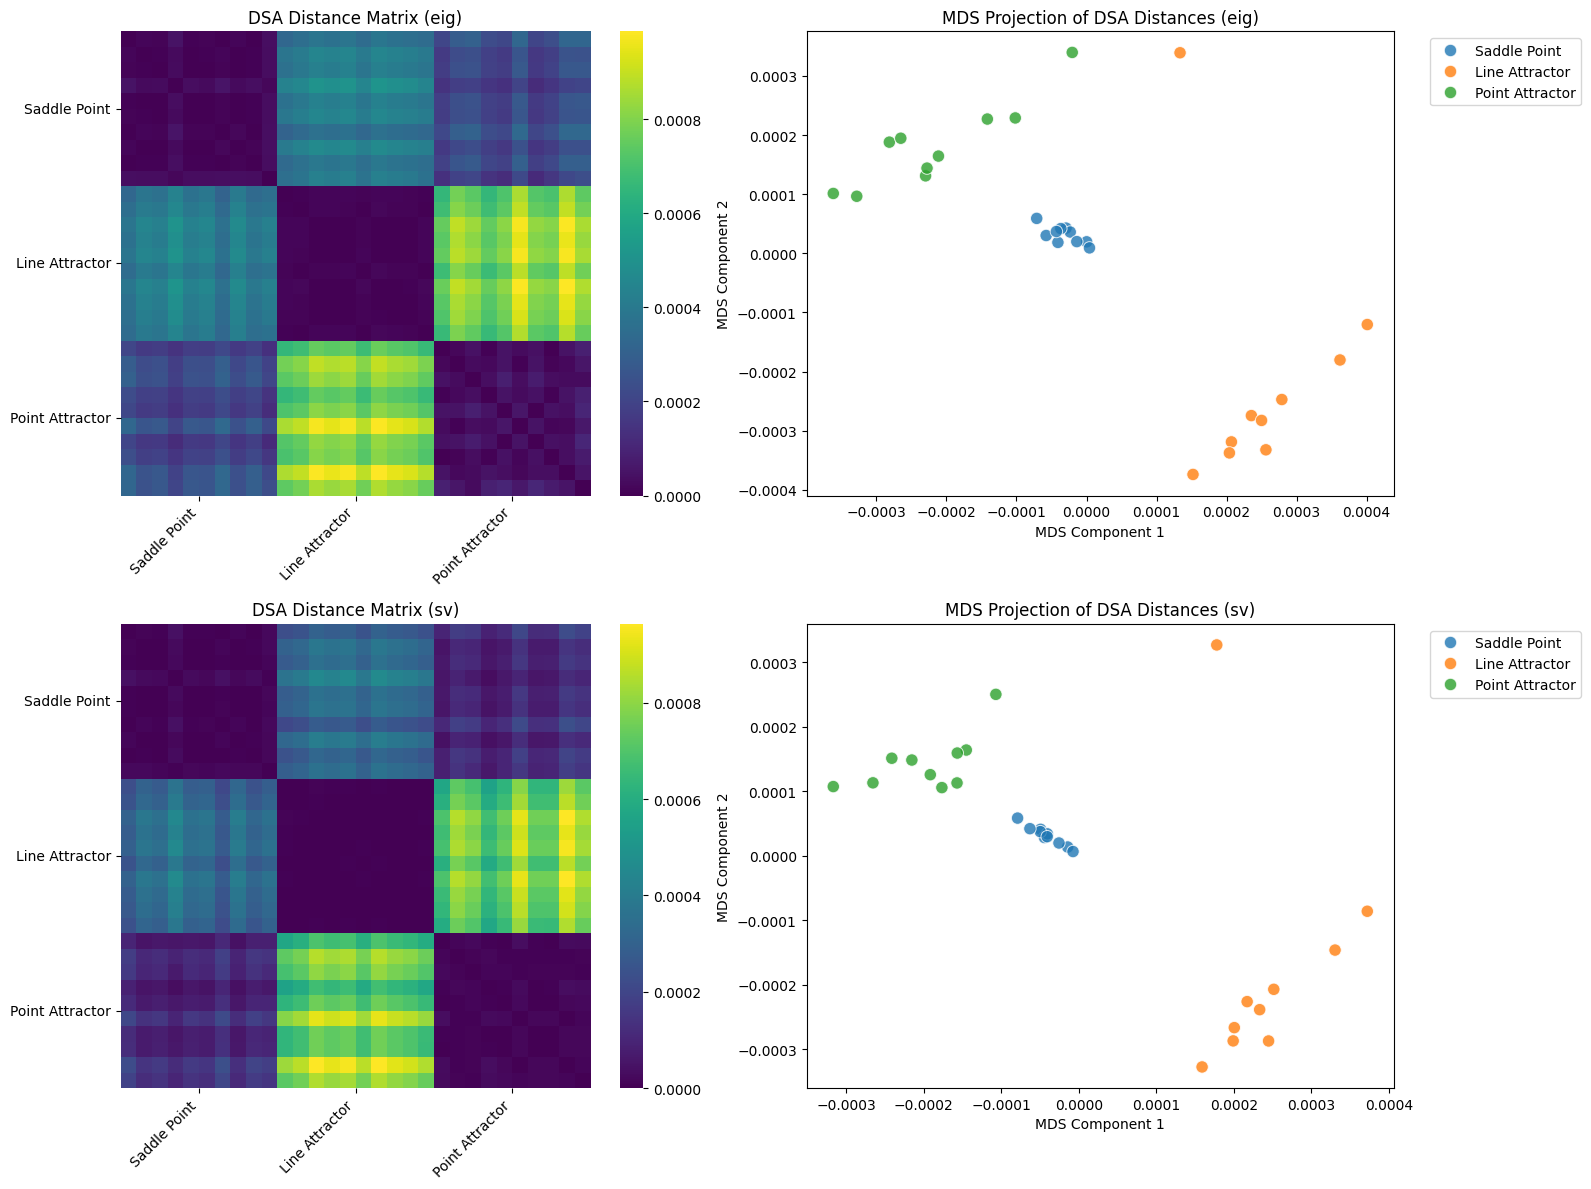

In [12]:
from DSA import DSA
from koopstd.datasets import PDMAttractors

pdm = PDMAttractors(n_samples=10, n_trials=100, sigma=0.05, simul_step=100, dt=0.01)
data = pdm.get_data()

info = {
    'types': ['Saddle Point', 'Line Attractor', 'Point Attractor'],
    'tick_positions': [5, 15, 25]
}

dsa_dist_matrices = []
silhouette_scores = []
for wasserstein_compare in ["eig", "sv"]:
    dsa = DSA(data, n_delays=50, rank=30, delay_interval=20, verbose=False, score_method="wasserstein", wasserstein_compare=wasserstein_compare, device="cuda")
    dsa_sim = dsa.fit_score()
    dsa_dist_matrices.append(dsa_sim)

    me = MetricEvaluator(distance_matrix=dsa_sim, cluster_sizes=[10, 10, 10])
    silhouette = me.evaluate()
    silhouette_scores.append(silhouette)

print(f"The silhouette scores of DSA: eigenvalues {silhouette_scores[0]}, singular values {silhouette_scores[1]}")
plt = plot_comparison(dsa_dist_matrices, "DSA", info)
plt.show()